In [72]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
print("Shape of data:", df.shape)
print("\nInfo:")
df.info()

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget value counts:")
print(df['Churn'].value_counts())


Shape of data: (7043, 21)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Paperless

In [74]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

df.drop("customerID", axis=1, inplace=True)

binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
], drop_first=True)



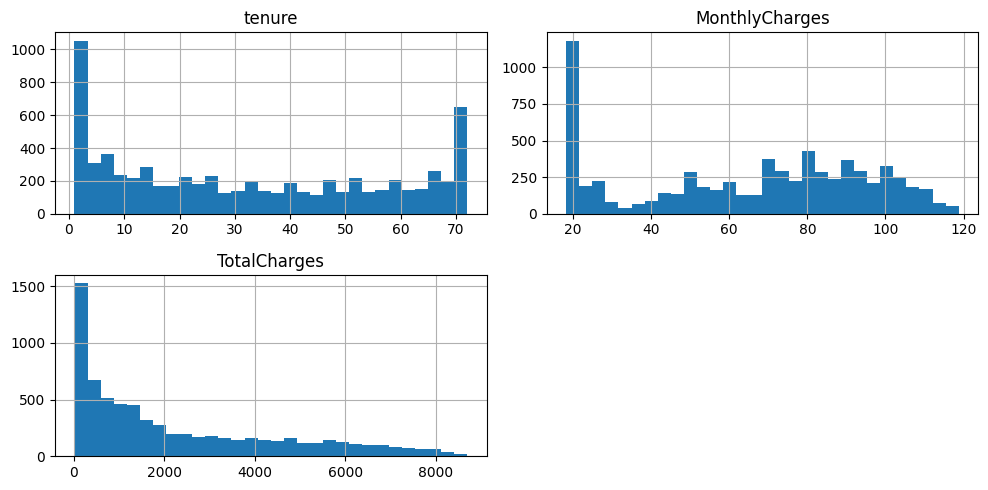

In [75]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df[num_features].hist(figsize=(10, 5), bins=30)
plt.tight_layout()
plt.show()


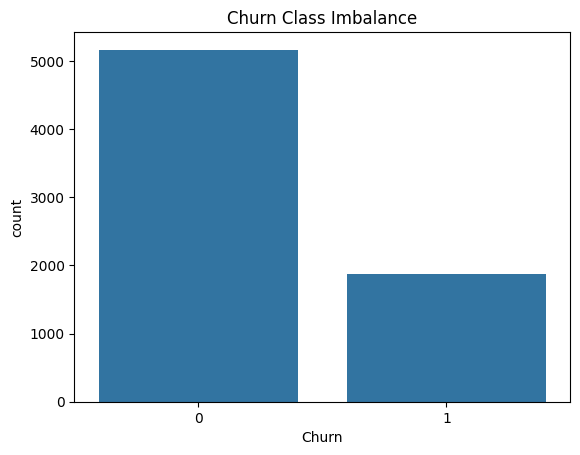

Top correlations with churn:
Churn                             1.000000
InternetService_Fiber optic       0.307463
PaymentMethod_Electronic check    0.301455
MonthlyCharges                    0.192858
PaperlessBilling                  0.191454
SeniorCitizen                     0.150541
StreamingTV_Yes                   0.063254
StreamingMovies_Yes               0.060860
MultipleLines_Yes                 0.040033
PhoneService                      0.011691
Name: Churn, dtype: float64


In [76]:
# Class balance
sns.countplot(x='Churn', data=df)
plt.title('Churn Class Imbalance')
plt.show()

# Correlation with target
correlation = df.corr()['Churn'].sort_values(ascending=False)
print("Top correlations with churn:")
print(correlation.head(10))


In [125]:
df['is_new_customer'] = (df['tenure'] <= 6).astype(int)
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 6, 12, 24, 48, 60, np.inf],
                            labels=['0-6m', '6-12m', '1-2y', '2-4y', '4-5y', '5y+'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)

df['avg_monthly_spend'] = df['TotalCharges'] / (df['tenure'] + 1)  # avoid div by zero
df['high_spender'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
df['bill_shock'] = ((df['MonthlyCharges'] > df['avg_monthly_spend'] * 1.25)).astype(int)

# Updated list to include one-hot encoded service columns
services = ['OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
            'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']

df['num_services'] = df[services].sum(axis=1) # Use sum for boolean columns
df['has_full_streaming'] = ((df['StreamingTV_Yes'] == 1) & (df['StreamingMovies_Yes'] == 1)).astype(int)
df['has_support'] = ((df['OnlineSecurity_Yes'] == 1) | (df['TechSupport_Yes'] == 1)).astype(int)

df['is_electronic_check'] = (df['PaymentMethod_Electronic check'] == 1).astype(int)
df['is_long_term_contract'] = ((df['Contract_One year'] == 1) | (df['Contract_Two year'] == 1)).astype(int)
df['short_term_electronic_check'] = ((df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0) & (df['PaymentMethod_Electronic check'] == 1)).astype(int)
df['high_spend_no_contract'] = ((df['MonthlyCharges'] > 70) & (df['Contract_One year'] == 0) & (df['Contract_Two year'] == 0)).astype(int)


df['has_dependents'] = (df['Dependents'] == 1).astype(int)
df['has_partner'] = (df['Partner'] == 1).astype(int)
df['is_senior'] = df['SeniorCitizen']

In [152]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

X=df.drop(columns='Churn')
y=df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Convert all bool columns to int
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes('bool').columns})




adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)


# Force NumPy arrays for safety
X_train_sm = X_res.to_numpy()
y_train_sm = y_res.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()


In [153]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# initialize models
models = {
    "Decision Tree (SMOTE)": DecisionTreeClassifier(random_state=42),
    "Random Forest (SMOTE)": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost (SMOTE)": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM (SMOTE)": LGBMClassifier(random_state=42)
}

# Train on SMOTE’d data
for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)

[LightGBM] [Info] Number of positive: 4149, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 8279, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501147 -> initscore=0.004590
[LightGBM] [Info] Start training from score 0.004590


In [154]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

for name, model in models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_np)
    print(f"\n📊 {name} Evaluation Metrics:")
    print(classification_report(y_test_np, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test_np, y_pred))



📊 Decision Tree (SMOTE) Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1033
           1       0.48      0.54      0.51       374

    accuracy                           0.72      1407
   macro avg       0.65      0.66      0.66      1407
weighted avg       0.73      0.72      0.72      1407

ROC-AUC Score: 0.6629683026955392

📊 Random Forest (SMOTE) Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1033
           1       0.56      0.61      0.58       374

    accuracy                           0.77      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.77      0.77      0.77      1407

ROC-AUC Score: 0.7153830026246176

📊 XGBoost (SMOTE) Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.60      0